## Test the segmentation of the images using OpenCV
#### Segmentation is done on a preprocessed image, where a proper threshold has been applied

In [181]:
import cv2
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from cv2 import cvtColor, COLOR_BGR2RGB

dataset_path = '../dataset/'
test_pictures_path = dataset_path + 'tif_merged_processed/'

In [182]:
picture = '1w_D Merged_Processed.tif'
picture_path = test_pictures_path + picture

______________________________

In [183]:
img = cv2.imread(picture_path, cv2.IMREAD_GRAYSCALE)
assert img is not None, 'No image found.'   # asert check if true, otherwise raise an AssertionError with an optional error message

### Proper thresholding to estimate the follicles

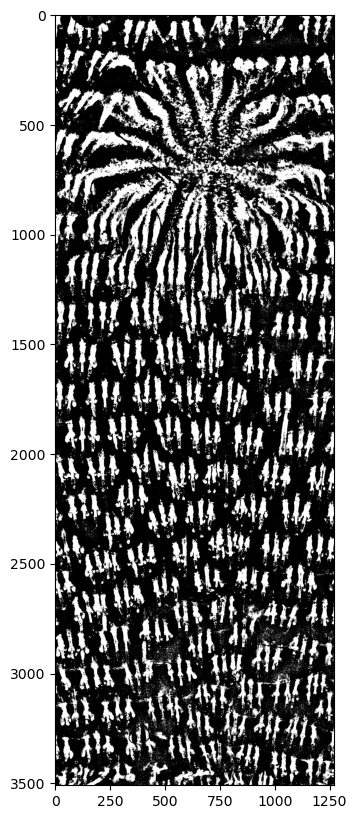

In [184]:
# thresholding with adaptive gaussian
thresh = cv2.adaptiveThreshold(img, 150, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 0)
plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap='gray')

Now we must remove the noise using morphological opening. By doing this we can define a "sure background", a "sure foreground" and an "unknown" region

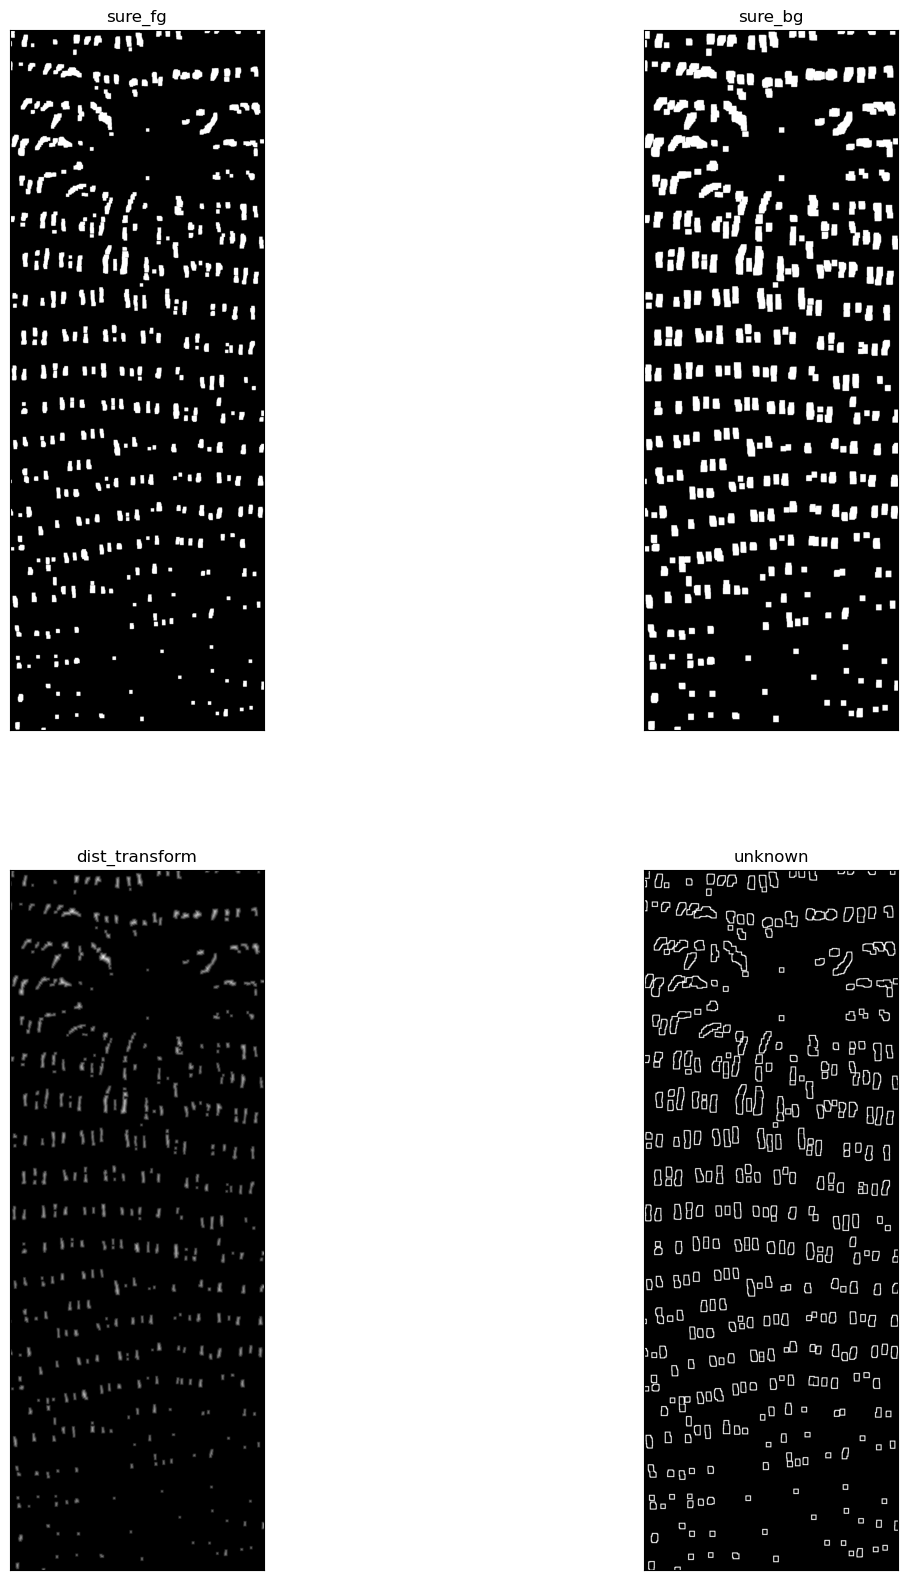

In [238]:
# Parameters one can tune
close_iterations = 4            # for morphological closing
open_iterations = 8             # for morphological opening
erode_iterations = 4               # for morphological erosion

dilate_interations = 5              # for morphological dilation

dist_transform_parameter = 0.0001      # for distance transform
metric = cv2.DIST_C                # cv2.DIST_L1 (Manhattan distance), 
                                    # cv2.DIST_L2 (Euclidean distance),
                                    # cv2.DIST_C  (Chebyshev distance)
distance_transform_mask_size = 3    # 3 or 5
max_sure_fg = 255
thresholding_type = cv2.THRESH_BINARY                                                   
#########################################################################################



# noise removal
kernel = np.ones((3, 3), np.uint8)                                          # 1x1 kernel with full of ones

open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=open_iterations)                         # opening = erosion followed by dilation, useful in removing noise

# sure background area
sure_bg = cv2.dilate(open, kernel, iterations=dilate_interations)                         # dilate = adds pixels to the boundaries of objects in an image

# sure foreground area
dist_transform = cv2.distanceTransform(open, metric, distance_transform_mask_size)                     # distanceTransform calculates the approximate or precise distance from every binary image pixel to the nearest zero pixel
ret, sure_fg = cv2.threshold(dist_transform, dist_transform_parameter* dist_transform.max(), max_sure_fg, thresholding_type)      # thresholding the distance transform image to obtain markers

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)                                    # subtracting sure_fg from sure_bg

# show sure_fg, sure_bg, dist_transform, unknown one next to the other
plt.figure(figsize=(15, 20))
plt.subplot(221), plt.imshow(sure_fg, cmap='gray')
plt.title('sure_fg'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(sure_bg, cmap='gray')
plt.title('sure_bg'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(dist_transform, cmap='gray')
plt.title('dist_transform'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(unknown, cmap='gray')
plt.title('unknown'), plt.xticks([]), plt.yticks([])
plt.show()


### Marker labelling and Watershed algorithm

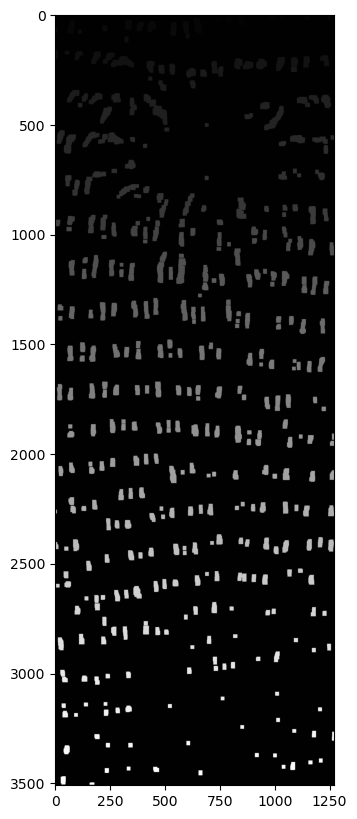

In [239]:
ret, markers = cv2.connectedComponents(sure_fg)                   # connectedComponents computes the connected components labeled image of boolean image
markers = markers + 1                                             # Add one to all labels so that sure background is not 0, but 1
markers[unknown == 200] = 0                                       # Now, mark the region of unknown with zero

# Watershed algorithm
markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)    # watershed = It is a segmentation algorithm, where the algorithm treats pixels values as a local topography (elevation)
plt.figure(figsize=(10, 10))
plt.imshow(markers, cmap='gray')
plt.show()

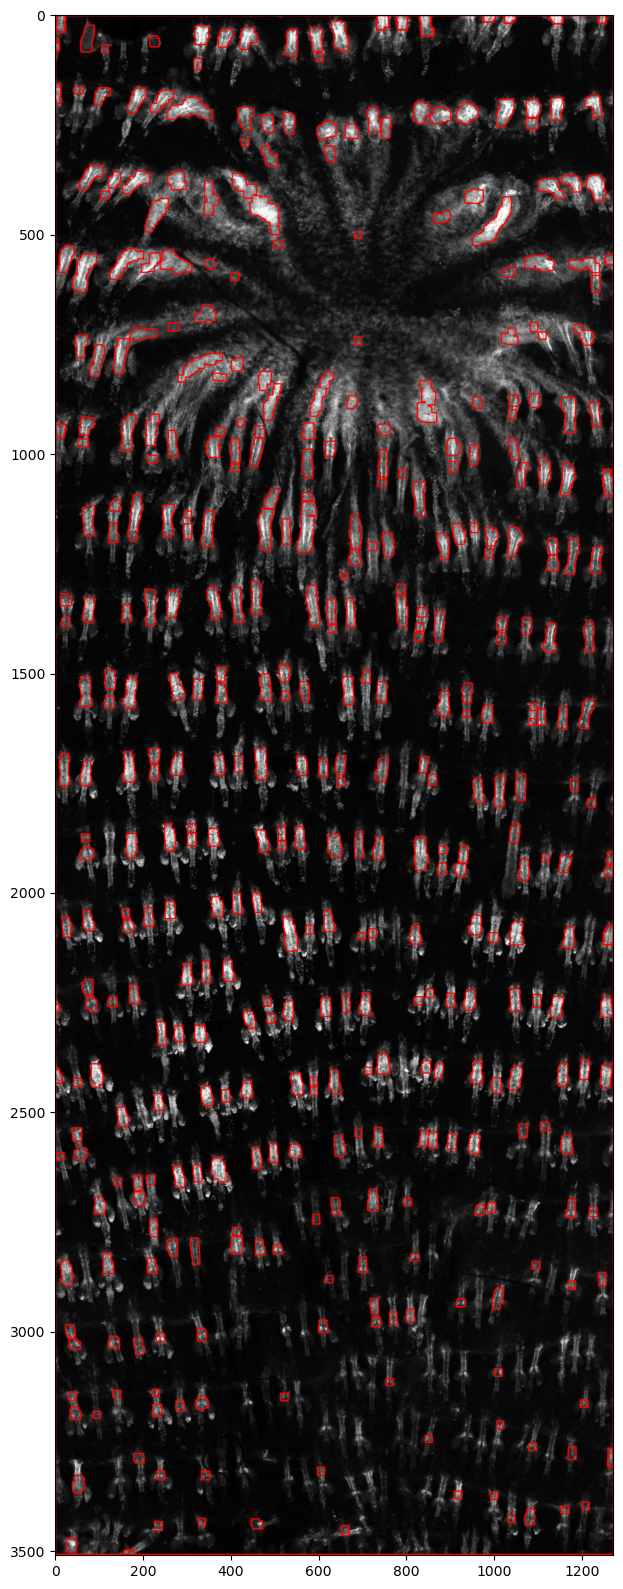

Number of cells:  803


In [240]:
# contouring the original image
img2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)   # findContours = finds contours in a binary image
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:    # if there is no child contour
        cv2.drawContours(img2, contours, i, (255, 0, 0), 2)   # drawContours = draws contours outlines or filled contours
plt.figure(figsize=(20, 20))
plt.imshow(img2)
plt.show()

print('Number of cells: ', len(contours))